## 0. **패키지 임포트**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn import metrics 
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
# import eli5 
# from eli5.sklearn import PermutationImportance 
# from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

## 1. **데이터 로드**
* 훈련에 필요없는 index 컬럼 삭제
* train : `train.csv`
* test : `test.csv`

In [2]:
# 데이터 불러오기
train = pd.read_csv('./train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./sample_submission.csv')

## 2. **데이터 셋 확인**


In [3]:
train.info()
test.info()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


#### 각 유형 갯수 확인
* object 8개, int64 7개 , float64 4개

In [4]:
count_type = [0, 0, 0] # object, int64, float64
for col in train.columns:
    if train[col].dtype == 'object':
        count_type[0] += 1
    elif train[col].dtype == 'int64':
        count_type[1] += 1
    elif train[col].dtype == 'float64':
        count_type[2] += 1
display(count_type)

[8, 7, 4]

## 3. **결측치 처리**
* 결측치는 직업 유형에만 존재
* income_type이 'Pensioner'인 경우 Retired, 아닌 경우 NaN으로 분류

In [5]:
# 결측치 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

훈련데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64
테스트데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64


In [6]:
# 결측치 처리
cond = (train['income_type'] == 'Pensioner')
train['occyp_type'] = train['occyp_type'].fillna(cond.map({True:'Retired', False: 'NaN'}))

cond = (test['income_type'] == 'Pensioner')
test['occyp_type'] = test['occyp_type'].fillna(cond.map({True:'Retired', False: 'NaN'}))

# 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

display(train)
display(test)

훈련데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64
테스트데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
dtype: int64


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,Retired,2.0,-60.0
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0


## 3. **이상치 처리**

### **3-1. 각 컬럼 데이터 변환 and 이상치 처리**

#### 1) 자녀 수

Text(0.5, 1.0, "Boxplot of train's child_num")

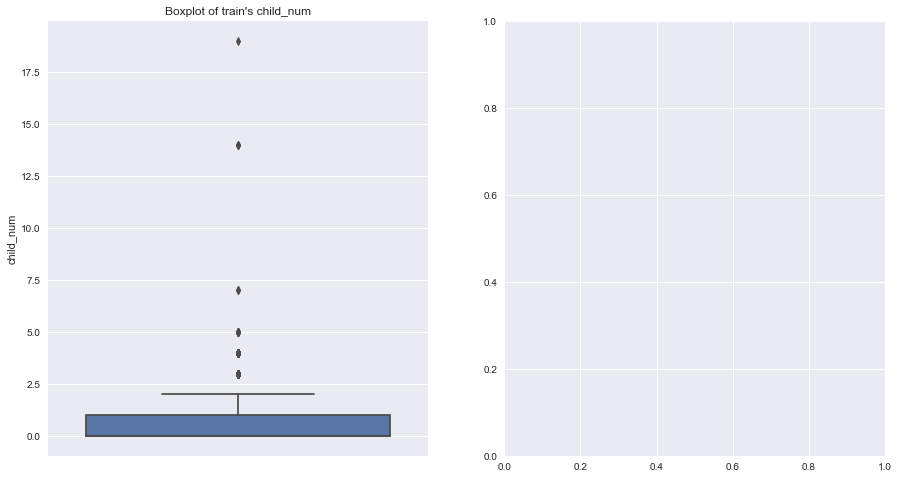

In [7]:
# 자녀 수에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["child_num"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's child_num")

In [8]:
print('train childnum unique:', train['child_num'].unique())

train childnum unique: [ 0  1  2  3  4  5 14 19  7]


* 박스플롯을 통해 3이상인 것을 이상치로 판단

In [9]:
# 아이가 3명 이상인 데이터는 2로 변경
train.loc[train['child_num'] >= 3,'child_num'] = 2
print('train childnum unique:', train['child_num'].unique())

test.loc[test['child_num'] >= 3,'child_num'] = 2
print('test childnum unique:', test['child_num'].unique())

train childnum unique: [0 1 2]
test childnum unique: [0 1 2]


#### 2) 가족 규모

In [10]:
print('train familysize unique:', train['family_size'].unique())

train familysize unique: [ 2.  3.  4.  1.  5.  6.  7. 15. 20.  9.]


Text(0.5, 1.0, "Boxplot of train's child_num")

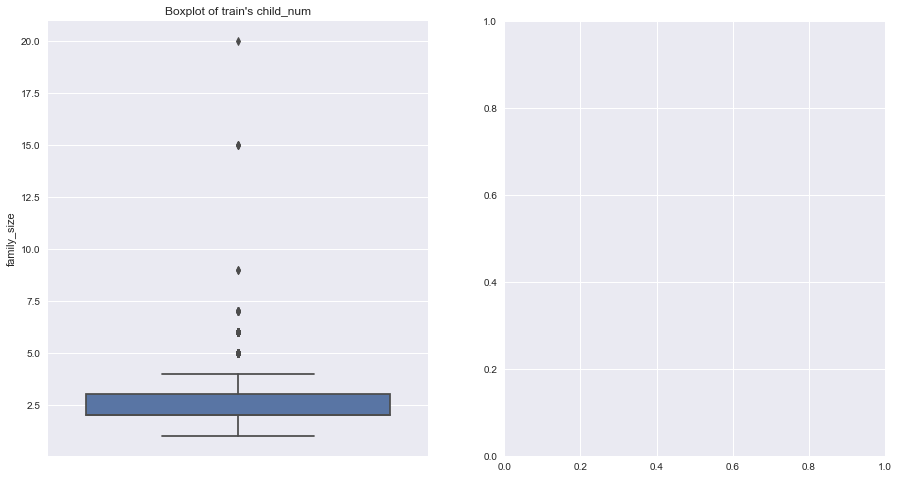

In [11]:
# 자녀 수에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["family_size"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's child_num")

In [12]:
# 가족규모가 5명 이상인 데이터는 4로 변경
train.loc[train['family_size'] >= 5,'family_size']=4
print('train familysize unique:', train['family_size'].unique())

test.loc[test['family_size'] >= 5,'family_size']=4
print('test familysize unique:', test['family_size'].unique())

train familysize unique: [2. 3. 4. 1.]
test familysize unique: [2. 1. 3. 4.]


#### 3) 연간 소득
* 이상치 확인

<AxesSubplot:xlabel='income_total'>

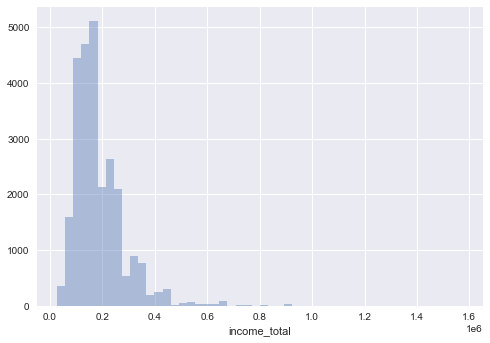

In [13]:
sns.distplot(train['income_total'], kde=False, label='income_total')

Text(0.5, 1.0, 'train Boxplot of income_total')

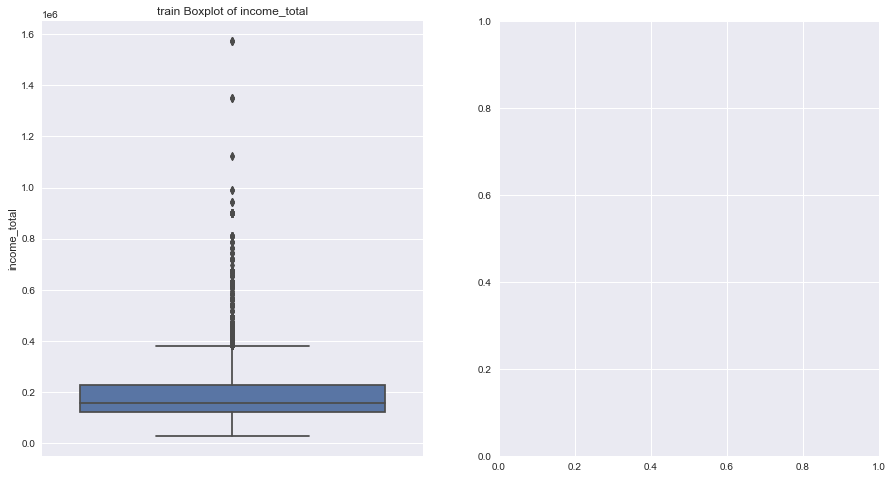

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.boxplot(y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("train Boxplot of income_total")

#### 4) 출생일
* 양수 변환

In [15]:
def days_to_age(x):
    return (x*-1)

# train
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(days_to_age)
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(train['DAYS_BIRTH'])

# test
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(days_to_age)
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(test['DAYS_BIRTH'])

0        13899
1        11380
2        19087
3        15088
4        15037
         ...  
26452    12079
26453    15291
26454    10082
26455    10145
26456    19569
Name: DAYS_BIRTH, Length: 26457, dtype: int32

0       21990
1       18964
2       15887
3       19270
4       17822
        ...  
9995    18593
9996    10886
9997    21016
9998    16541
9999     9154
Name: DAYS_BIRTH, Length: 10000, dtype: int32

#### 5) 업무시작일 -> 업무 연차
* 양수 변환
    * 단, 365243(일한적 없음)은 음수로 변환

In [16]:
def days_to_year(x):
    if x==365243 :
        return 0
    return (x*-1)

# train
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(days_to_year)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(train['DAYS_EMPLOYED'])

# test
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(days_to_year)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(test['DAYS_EMPLOYED'])

0        4709
1        1540
2        4434
3        2092
4        2105
         ... 
26452    1984
26453    2475
26454    2015
26455     107
26456    1013
Name: DAYS_EMPLOYED, Length: 26457, dtype: int32

0           0
1        8671
2         217
3        2531
4        9385
        ...  
9995     5434
9996     1315
9997    14018
9998     1085
9999      187
Name: DAYS_EMPLOYED, Length: 10000, dtype: int32

#### 6) 신용카드 발급 월

* 양수로 변환

In [17]:
def minus(x):
    return x * -1

# train
train['begin_month'] = train['begin_month'].apply(minus)
display(train['begin_month'])

# test
test['begin_month'] = test['begin_month'].apply(minus)
display(test['begin_month'])

0         6.0
1         5.0
2        22.0
3        37.0
4        26.0
         ... 
26452     2.0
26453    47.0
26454    25.0
26455    59.0
26456     9.0
Name: begin_month, Length: 26457, dtype: float64

0       60.0
1       36.0
2       40.0
3       41.0
4        8.0
        ... 
9995    19.0
9996    34.0
9997    55.0
9998    33.0
9999    11.0
Name: begin_month, Length: 10000, dtype: float64

## 4. **Feature Engineering**
* 다중 공신성 제거 (child_num, family_num)
* 범주형 데이터 one-hot encoding
* 데이터 정규화 (RobustScaler)

### 4-1. 다중 공신성 제거
* child_num과 family_num의 상관관계가 높음

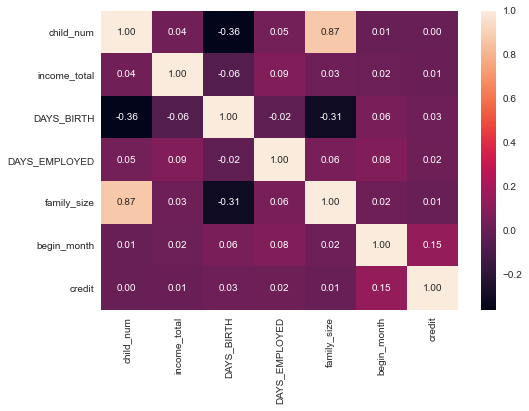

In [18]:
# 다중 공선성 확인
list_numeric = ["child_num", "income_total", "DAYS_BIRTH", "DAYS_EMPLOYED", "family_size", "begin_month", "credit"]
sns.heatmap(train[list_numeric].corr(), annot = True, fmt = ".2f")
plt.show()

In [19]:
# child_num 변수 제거
train = train.drop(['child_num'], axis=1)
test = test.drop(['child_num'], axis=1)

In [20]:
display(train.head(5))
display(test.head(5))

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,1,0,0,0,NaN,2.0,6.0,1.0
1,F,N,Y,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,1,0,0,1,Laborers,3.0,5.0,1.0
2,M,Y,Y,450000.0,Working,Higher education,Married,House / apartment,19087,4434,1,0,1,0,Managers,2.0,22.0,2.0
3,F,N,Y,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,1,0,1,0,Sales staff,2.0,37.0,0.0
4,F,Y,Y,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,1,0,0,0,Managers,2.0,26.0,2.0


,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,M,Y,N,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,21990,0,1,0,1,0,Retired,2.0,60.0
1,F,N,Y,135000.0,State servant,Higher education,Married,House / apartment,18964,8671,1,0,1,0,Core staff,2.0,36.0
2,F,N,Y,69372.0,Working,Secondary / secondary special,Married,House / apartment,15887,217,1,1,1,0,Laborers,2.0,40.0
3,M,Y,N,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,19270,2531,1,1,0,0,Drivers,2.0,41.0
4,F,Y,Y,225000.0,State servant,Higher education,Married,House / apartment,17822,9385,1,1,0,0,Managers,2.0,8.0


### 4-2. 범주형 데이터 one-hot encoding
* object(범주형) 원핫인코딩
* 범주형 데이터
    * gender(2), car(2), reality(2), income_type(5), edu_type(5), family_type(5), house_type(6), occyp_type(18)

In [21]:
# object 객체를 가지는 변수(열) 확인
object_col = []
for col in train.columns:
    if train[col].dtype == 'object' :
        object_col.append(col)
display(object_col)

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

#### train의 원핫인코딩

In [22]:
enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])

train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))

train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [23]:
# 인코딩 확인
display(train.head(5))
train.info()

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,202500.0,13899,4709,1,0,0,0,2.0,6.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,247500.0,11380,1540,1,0,0,1,3.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,450000.0,19087,4434,1,0,1,0,2.0,22.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,202500.0,15088,2092,1,0,1,0,2.0,37.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,157500.0,15037,2105,1,0,0,0,2.0,26.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   income_total                            26457 non-null  float64
 1   DAYS_BIRTH                              26457 non-null  int32  
 2   DAYS_EMPLOYED                           26457 non-null  int32  
 3   FLAG_MOBIL                              26457 non-null  int64  
 4   work_phone                              26457 non-null  int64  
 5   phone                                   26457 non-null  int64  
 6   email                                   26457 non-null  int64  
 7   family_size                             26457 non-null  float64
 8   begin_month                             26457 non-null  float64
 9   credit                                  26457 non-null  float64
 10  gender_F                                26457 non-null  fl

#### test의 원핫인코딩

In [24]:
enc = OneHotEncoder()
enc.fit(test.loc[:,object_col])

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [25]:
# 인코딩 확인
display(test)
test.info()

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,gender_F,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,112500.0,21990,0,1,0,1,0,2.0,60.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,135000.0,18964,8671,1,0,1,0,2.0,36.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,69372.0,15887,217,1,1,1,0,2.0,40.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,112500.0,19270,2531,1,1,0,0,2.0,41.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,225000.0,17822,9385,1,1,0,0,2.0,8.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,202500.0,18593,5434,1,1,1,0,2.0,19.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,202500.0,10886,1315,1,1,0,0,2.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,292500.0,21016,14018,1,0,0,0,2.0,55.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,180000.0,16541,1085,1,0,1,0,2.0,33.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   income_total                            10000 non-null  float64
 1   DAYS_BIRTH                              10000 non-null  int32  
 2   DAYS_EMPLOYED                           10000 non-null  int32  
 3   FLAG_MOBIL                              10000 non-null  int64  
 4   work_phone                              10000 non-null  int64  
 5   phone                                   10000 non-null  int64  
 6   email                                   10000 non-null  int64  
 7   family_size                             10000 non-null  float64
 8   begin_month                             10000 non-null  float64
 9   gender_F                                10000 non-null  float64
 10  gender_M                                10000 non-null  flo

### 4-3. 데이터 정규화 (RobustScaler)
* 이상치에 덜 민감한 RobustScaler 선택

#### RobustScaler

In [26]:
from sklearn.preprocessing import RobustScaler

RobustScaler_train = train.drop(['credit'], axis=1)

# scaler 생성 및 fit
robustScaler = RobustScaler()
print(robustScaler.fit(RobustScaler_train))


### train data - trainsform
train_data = robustScaler.transform(RobustScaler_train)
# StandardScaler_data(StandardScaler 적용한 데이터 프레임)
index = 0
for col in RobustScaler_train.columns :
    RobustScaler_train[col] = train_data[:,index]
    index = index + 1

    
### test data - trainsform
RobustScaler_test = test.copy()
test_data = robustScaler.transform(RobustScaler_test)

index = 0
for col in RobustScaler_test.columns :
    RobustScaler_test[col] = test_data[:,index]
    index = index + 1


display(train[['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month']])
display(RobustScaler_train[['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month']])

display(test[['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month']])
display(RobustScaler_test[['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month']])

RobustScaler()


,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month
0,202500.0,13899,4709,2.0,6.0
1,247500.0,11380,1540,3.0,5.0
2,450000.0,19087,4434,2.0,22.0
3,202500.0,15088,2092,2.0,37.0
4,157500.0,15037,2105,2.0,26.0
...,...,...,...,...,...
26452,225000.0,12079,1984,4.0,2.0
26453,180000.0,15291,2475,2.0,47.0
26454,292500.0,10082,2015,2.0,25.0
26455,171000.0,10145,107,1.0,59.0


,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month
0,0.434783,-0.235934,1.154406,0.0,-0.666667
1,0.869565,-0.596564,0.000364,1.0,-0.703704
2,2.826087,0.506800,1.054261,0.0,-0.074074
3,0.434783,-0.065712,0.201384,0.0,0.481481
4,0.000000,-0.073014,0.206118,0.0,0.074074
...,...,...,...,...,...
26452,0.652174,-0.496492,0.162054,2.0,-0.814815
26453,0.217391,-0.036650,0.340859,0.0,0.851852
26454,1.304348,-0.782391,0.173343,0.0,0.037037
26455,0.130435,-0.773372,-0.521486,-1.0,1.296296


,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month
0,112500.0,21990,0,2.0,60.0
1,135000.0,18964,8671,2.0,36.0
2,69372.0,15887,217,2.0,40.0
3,112500.0,19270,2531,2.0,41.0
4,225000.0,17822,9385,2.0,8.0
...,...,...,...,...,...
9995,202500.0,18593,5434,2.0,19.0
9996,202500.0,10886,1315,2.0,34.0
9997,292500.0,21016,14018,2.0,55.0
9998,180000.0,16541,1085,2.0,33.0


,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month
0,-0.434783,0.922405,-0.560452,0.0,1.333333
1,-0.217391,0.489191,2.597232,0.0,0.444444
2,-0.851478,0.048676,-0.481428,0.0,0.592593
3,-0.434783,0.532999,0.361253,0.0,0.629630
4,0.652174,0.325698,2.857247,0.0,-0.592593
...,...,...,...,...,...
9995,0.434783,0.436077,1.418427,0.0,-0.185185
9996,0.434783,-0.667287,-0.081573,0.0,0.370370
9997,1.304348,0.782963,4.544428,0.0,1.148148
9998,0.217391,0.142305,-0.165331,0.0,0.333333


<AxesSubplot:xlabel='begin_month', ylabel='Density'>

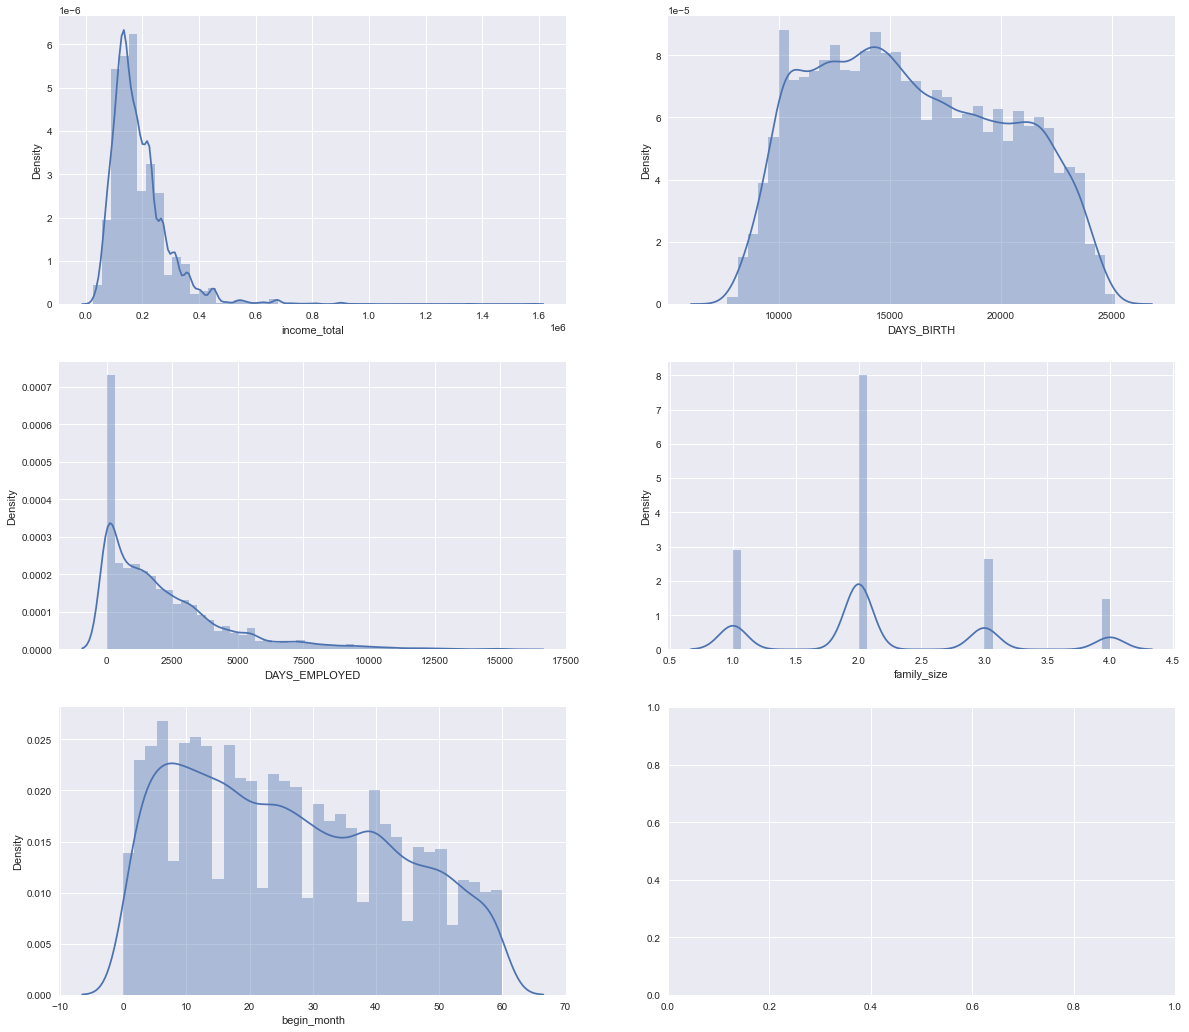

In [27]:
# 정규화 전 데이터
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(train['income_total'], ax=ax[0][0])
sns.distplot(train['DAYS_BIRTH'], ax=ax[0][1])

sns.distplot(train['DAYS_EMPLOYED'], ax=ax[1][0])
sns.distplot(train['family_size'], ax=ax[1][1])

sns.distplot(train['begin_month'], ax=ax[2][0])

<AxesSubplot:xlabel='begin_month', ylabel='Density'>

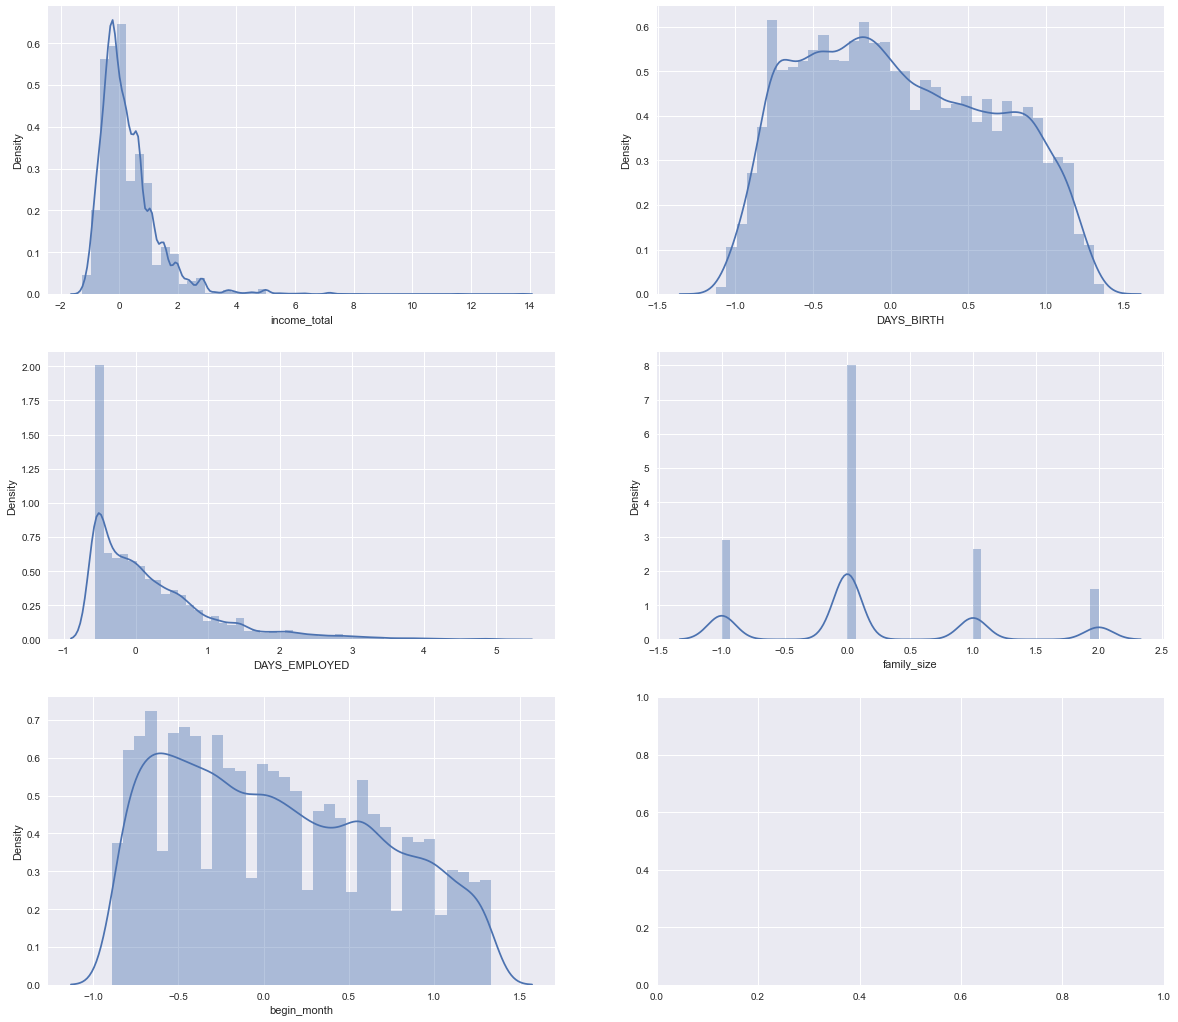

In [28]:
# 정규화 후 데이터
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(RobustScaler_train['income_total'], ax=ax[0][0])
sns.distplot(RobustScaler_train['DAYS_BIRTH'], ax=ax[0][1])

sns.distplot(RobustScaler_train['DAYS_EMPLOYED'], ax=ax[1][0])
sns.distplot(RobustScaler_train['family_size'], ax=ax[1][1])

sns.distplot(RobustScaler_train['begin_month'], ax=ax[2][0])

## 5. 모델링

### 5-1 데이터 분리
* 데이터 분리는 stratifiedKFold를 사용하여 y값 분포를 비슷하게 분리 시킴 -> 5-fold
    * StratifiedKFold(계층별 k-겹 교차검증) - 불균형한 분포도를 가진 레이블 데이터를 위한 방식, 특정 레이블 값이 너무 많거나 적은 경우
    * 타겟에 속성값의 개수를 동일하게 가져감으로써 kfold 같이 데이터가 한곳으로 몰리는 것을 방지
    * 대부분의 경우 회귀에서는 k-겹 교차 검증, 분류에서는 계층별 k-겹 교차검증의 기본값이 잘 작동함
* n_split는 몇 개로 분할할지 결정
* shtffle은 데이터 섞어서 샘플의 순서 랜덤하게. 
* 데이터를 섞을 때 random_state를 고정해서 똑같은 작업을 재현할 수있음
* 그렇지 않으면 cross_val_score를 실행할 때마다 폴드가 바뀌어 매번 결과가 달라짐

In [29]:
# 설명변수 X, 예측변수 y 할당 (사용하고자하는 정규화 스케일러로 변경 가능)
X = RobustScaler_train
Y = train['credit']

In [30]:
display(X)
display(RobustScaler_test)

,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,gender_F,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,0.434783,-0.235934,1.154406,0.0,0.0,0.0,0.0,0.0,-0.666667,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.869565,-0.596564,0.000364,0.0,0.0,0.0,1.0,1.0,-0.703704,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.826087,0.506800,1.054261,0.0,0.0,1.0,0.0,0.0,-0.074074,-1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.434783,-0.065712,0.201384,0.0,0.0,1.0,0.0,0.0,0.481481,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,-0.073014,0.206118,0.0,0.0,0.0,0.0,0.0,0.074074,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.652174,-0.496492,0.162054,0.0,0.0,0.0,0.0,2.0,-0.814815,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26453,0.217391,-0.036650,0.340859,0.0,0.0,0.0,0.0,0.0,0.851852,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26454,1.304348,-0.782391,0.173343,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26455,0.130435,-0.773372,-0.521486,0.0,0.0,0.0,0.0,-1.0,1.296296,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,gender_F,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_NaN,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Retired,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,-0.434783,0.922405,-0.560452,0.0,0.0,1.0,0.0,0.0,1.333333,-1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.217391,0.489191,2.597232,0.0,0.0,1.0,0.0,0.0,0.444444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.851478,0.048676,-0.481428,0.0,1.0,1.0,0.0,0.0,0.592593,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.434783,0.532999,0.361253,0.0,1.0,0.0,0.0,0.0,0.629630,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.652174,0.325698,2.857247,0.0,1.0,0.0,0.0,0.0,-0.592593,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.434783,0.436077,1.418427,0.0,1.0,1.0,0.0,0.0,-0.185185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.434783,-0.667287,-0.081573,0.0,1.0,0.0,0.0,0.0,0.370370,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,1.304348,0.782963,4.544428,0.0,0.0,0.0,0.0,0.0,1.148148,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.217391,0.142305,-0.165331,0.0,0.0,1.0,0.0,0.0,0.333333,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
folds=[]

# 계층별 k-겹 교차검증을 위해 인덱스를 나누는 코드
for train_index, valid_index in skf.split(train, train['credit']):
    folds.append((train_index, valid_index))
display(folds)

[(array([    0,     1,     3, ..., 26453, 26454, 26456]),
  array([    2,    26,    45, ..., 26446, 26452, 26455])),
 (array([    1,     2,     3, ..., 26454, 26455, 26456]),
  array([    0,     8,    11, ..., 26415, 26416, 26445])),
 (array([    0,     2,     3, ..., 26454, 26455, 26456]),
  array([    1,     4,     5, ..., 26438, 26447, 26450])),
 (array([    0,     1,     2, ..., 26453, 26454, 26455]),
  array([    3,    17,    19, ..., 26437, 26448, 26456])),
 (array([    0,     1,     2, ..., 26454, 26455, 26456]),
  array([   29,    32,    34, ..., 26440, 26442, 26453])),
 (array([    0,     1,     2, ..., 26454, 26455, 26456]),
  array([    6,    14,    18, ..., 26436, 26443, 26449])),
 (array([    0,     1,     2, ..., 26453, 26455, 26456]),
  array([    7,     9,    10, ..., 26444, 26451, 26454]))]

* 여기서 앞으로 계속 사용할 X,Y, folds 저장되어 있음

### LGBM
[LGBM 모델 설명](https://lsjsj92.tistory.com/548)
#### Training    
* LGBM의 기본 파라미터로 훈련
* 30번 이상 개선 없을 경우 중단.
* 각 5개의 fold를 훈련하여 저장

In [46]:
random.seed(42)
lgb_models={}

for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # LGBM 모델 돌리기, 
    # 30번 이상 개선 없을 시 중단, 5개의 fold를 훈련하여 저장
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    
    y_hat = lgb.predict(X_valid)
    lgb_matrix = metrics.confusion_matrix(Y_valid, y_hat)

    print(lgb_matrix)
    lgb_report = metrics.classification_report(Y_valid, y_hat)
    print(lgb_report)
    lgb_models[fold]=lgb
    
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.655832	valid_1's multi_logloss: 0.740753
[200]	training's multi_logloss: 0.573206	valid_1's multi_logloss: 0.723285
[300]	training's multi_logloss: 0.51194	valid_1's multi_logloss: 0.714262
[400]	training's multi_logloss: 0.460959	valid_1's multi_logloss: 0.711853
Early stopping, best iteration is:
[383]	training's multi_logloss: 0.468829	valid_1's multi_logloss: 0.711492
[[  80   50  330]
 [  12  329  555]
 [  39   65 2320]]
              precision    recall  f1-score   support

         0.0       0.61      0.17      0.27       460
         1.0       0.74      0.37      0.49       896
         2.0       0.72      0.96      0.82      2424

    accuracy                           0.72      3780
   macro avg       0.69      0.50      0.53      3780
weighted avg       0.71      0.72      0.68      3780



==========

#### Test inference
* 각 폴드를 훈련시킨 LGBM으로 예측
* 해당 대회는 logloss score를 겨루는 것이기 때문에 각 class의 probability를 얻어야함
* 대부분의 머신러닝 모델에서 predict, predict_proba를 구분하여 사용함.
* predict는 class 출력을 해주고 predict_proba는 class 별 probability를 출력해줌
* predict_proba를 사용하여 예측한 것을 5-fold 더하여 평균내어 앙상블함

In [44]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(RobustScaler_test)/7
submit.to_csv('./final_submission.csv', index=False)
submit.head(20)

,index,0,1,2
0,26457,0.026429,0.048655,0.424916
1,26458,0.113515,0.096055,0.290430
2,26459,0.021236,0.056979,0.421785
3,26460,0.056375,0.060728,0.382897
4,26461,0.041344,0.092129,0.366527
5,26462,0.032343,0.078330,0.389327
6,26463,0.271089,0.228751,0.000159
7,26464,0.048532,0.075415,0.376054
8,26465,0.023675,0.048094,0.428231
9,26466,0.024790,0.156425,0.318785


### 5-2. **로지스틱 회귀분석**

In [69]:
random.seed(42)
logR_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    logmodel = LogisticRegression()
    logmodel.fit(X_train, Y_train)  
    y_hat = logmodel.predict(X_valid)
    
    logR_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(logR_matrix)
    logR_report = metrics.classification_report(Y_valid, y_hat)
    print(logR_report)
    
    print('학습용 데이터셋 정확도 : %.5f' % logmodel.score(X_train, Y_train))
    print('검증용 데이터셋 정확도 : %.5f' % logmodel.score(X_valid, Y_valid))
    print(f'Log Loss: {log_loss(Y_valid, logmodel.predict_proba(X_valid)):.6f}')
    logR_models[fold]=logmodel
    print(f'================================================================================\n\n')

====================================1============================================
[[   0   11  634]
 [   0   26 1228]
 [   0   16 3377]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       645
         1.0       0.49      0.02      0.04      1254
         2.0       0.64      1.00      0.78      3393

    accuracy                           0.64      5292
   macro avg       0.38      0.34      0.27      5292
weighted avg       0.53      0.64      0.51      5292

학습용 데이터셋 정확도 : 0.64352
검증용 데이터셋 정확도 : 0.64305
Log Loss: 0.867013


====================================2============================================
[[   0    5  640]
 [   0   19 1235]
 [   0    8 3385]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       645
         1.0       0.59      0.02      0.03      1254
         2.0       0.64      1.00      0.78      3393

    accuracy                           0.64      5292
   mac

In [70]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += logR_models[fold].predict_proba(RobustScaler_test)/5

submit.to_csv('./logR_submission.csv', index=False)
submit.head(20)

,index,0,1,2
0,26457,0.097087,0.104527,0.798385
1,26458,0.127162,0.176312,0.696526
2,26459,0.120191,0.186338,0.693471
3,26460,0.100408,0.138043,0.761550
4,26461,0.149805,0.301886,0.548309
5,26462,0.135505,0.349438,0.515058
6,26463,0.171543,0.236120,0.592337
7,26464,0.144805,0.328145,0.527051
8,26465,0.114465,0.220646,0.664889
9,26466,0.110995,0.230908,0.658097


### 5-3 KNN

In [ ]:
# # 시간 진 ~ 짜 오래걸리니까 ... 변한거 없으면 그냥 돌리지 마세요 ....!

# # 최적 k 도출 - Cross Validation 이용
# from sklearn.model_selection import cross_val_score
# from sklearn.neighbors import KNeighborsClassifier

# k_range = range(1,50) # 1~100 에서 최적 k 찾기
# k_scores = []

# for k in k_range :
#     print(k)
#     knn = KNeighborsClassifier(k)
#     scores = cross_val_score(knn, X, y, cv=10, scoring = "accuracy") # 10-fold cross validation
#     k_scores.append(scores.mean())
    

# # 최적 k를 그래프로 확인    
# plt.plot(k_range, k_scores)
# plt.xlabel('value of K for KNN')
# plt.ylabel('Cross_Validation Accuracy')
# plt.show()

# # k_scores 리스트에서 최댓값의 index 구하기 (최적 k 찾기)
# k = k_scores.index(max(k_scores)) + 1
# print(k)

In [45]:
random.seed(42)

# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn import metrics 

knn_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # knn 모델
    knn = KNeighborsClassifier(n_neighbors=75) # 75로 해놓음
    knn.fit(X_train, Y_train)
    y_hat = knn.predict(X_valid)
    
    knn_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(knn_matrix)
    
    knn_report = metrics.classification_report(Y_valid, y_hat)
    print(knn_report)

    print(log_loss(Y_valid, knn.predict_proba(X_valid)))

    knn_models[fold]=knn
    print(f'================================================================================\n\n')

====================================1============================================
[[   0    4  641]
 [   0   36 1218]
 [   0   33 3360]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       645
         1.0       0.49      0.03      0.05      1254
         2.0       0.64      0.99      0.78      3393

    accuracy                           0.64      5292
   macro avg       0.38      0.34      0.28      5292
weighted avg       0.53      0.64      0.51      5292

0.8682800546602732


====================================2============================================
[[   0    6  639]
 [   0   33 1221]
 [   0   19 3374]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       645
         1.0       0.57      0.03      0.05      1254
         2.0       0.64      0.99      0.78      3393

    accuracy                           0.64      5292
   macro avg       0.40      0.34      0.28      529

In [46]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += knn_models[fold].predict_proba(RobustScaler_test)/5

submit.to_csv('./knn_0422.csv', index=False)
submit.head(20)

,index,0,1,2
0,26457,0.130667,0.096000,0.773333
1,26458,0.253333,0.154667,0.592000
2,26459,0.122667,0.237333,0.640000
3,26460,0.242667,0.130667,0.626667
4,26461,0.165333,0.288000,0.546667
5,26462,0.021333,0.296000,0.682667
6,26463,0.213333,0.130667,0.656000
7,26464,0.144000,0.285333,0.570667
8,26465,0.053333,0.152000,0.794667
9,26466,0.061333,0.349333,0.589333


### 5-4. SVM (주의: 시간 오래 걸림)

In [ ]:
random.seed(42)

SVM_models={}

for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    svm_model = svm.SVC(C=1, gamma = 10, kernel='rbf', probability=True)
    svm_model.fit(X_train, Y_train)   
    y_hat = svm_model.predict(X_valid)
    svm_matrix = metrics.confusion_matrix(Y_valid, y_hat)  
    print(svm_matrix)
    print('\n')
    svm_report = metrics.classification_report(Y_valid, y_hat)            
    print(svm_report)
    print(svm_model.predict_proba(X_valid))
    print('log_loss :', log_loss(Y_valid, svm_model.predict_proba(X_valid)))
    SVM_models[fold]=svm_model
    print(f'================================================================================\n\n')

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += SVM_models[fold].predict_proba(RobustScaler_test)/5

submit.to_csv('./SVM_0422.csv', index=False)
submit.head(20)

### 5-5. 랜덤포레스트

In [47]:
random.seed(42)

rfc_models={}

for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    rfc = RandomForestClassifier(n_estimators=200,random_state=30, max_depth=10,n_jobs=-1)
    rfc.fit(X_train, Y_train)
    
    
    y_hat = rfc.predict(X_valid)
    
    rfc_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(rfc_matrix)
    
    rfc_report = metrics.classification_report(Y_valid, y_hat)
    print(rfc_report)
    
    print(f'Log Loss: {log_loss(Y_valid, rfc.predict_proba(X_valid)):.6f}')
    rfc_models[fold]=rfc
    print(f'================================================================================\n\n')

====================================1============================================
[[   0   74  571]
 [   0  284  970]
 [   0    3 3390]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       645
         1.0       0.79      0.23      0.35      1254
         2.0       0.69      1.00      0.81      3393

    accuracy                           0.69      5292
   macro avg       0.49      0.41      0.39      5292
weighted avg       0.63      0.69      0.61      5292

Log Loss: 0.788766


====================================2============================================
[[   2   71  572]
 [   0  271  983]
 [   0    7 3386]]
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.01       645
         1.0       0.78      0.22      0.34      1254
         2.0       0.69      1.00      0.81      3393

    accuracy                           0.69      5292
   macro avg       0.82      0.41      0.39      529

In [49]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += rfc_models[fold].predict_proba(RobustScaler_test)/5

submit.to_csv('./rfc_0422.csv', index=False)
submit.head(20)

,index,0,1,2
0,26457,0.105315,0.191636,0.703048
1,26458,0.128070,0.186391,0.685539
2,26459,0.115698,0.201636,0.682665
3,26460,0.117809,0.169921,0.712269
4,26461,0.120023,0.187407,0.692571
5,26462,0.105658,0.226380,0.667962
6,26463,0.236875,0.569130,0.193995
7,26464,0.122634,0.211468,0.665898
8,26465,0.101007,0.183607,0.715386
9,26466,0.091753,0.236340,0.671907


### 5-6. xgboost

In [48]:
random.seed(42)

xgb_models={}

for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # xgb
    xgb = XGBClassifier()
    #xgb.fit(X_train, Y_train)
    
    xgb.fit(X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            early_stopping_rounds=30,
           verbose=300)
    
    y_hat = xgb.predict(X_valid)
    
    xgb_matrix = metrics.confusion_matrix(Y_valid, y_hat)
    print(xgb_matrix)
    
    xgb_report = metrics.classification_report(Y_valid, y_hat)
    print(xgb_report)
    
    print(f'Log Loss: {log_loss(Y_valid, xgb.predict_proba(X_valid)):.6f}')
    xgb_models[fold]=xgb
    
    print(f'================================================================================\n\n')

====================================1============================================
[16:27:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.97436	validation_1-mlogloss:0.97749
[99]	validation_0-mlogloss:0.57295	validation_1-mlogloss:0.73336
[[  63   84  498]
 [  20  388  846]
 [  28   58 3307]]
              precision    recall  f1-score   support

         0.0       0.57      0.10      0.17       645
         1.0       0.73      0.31      0.43      1254
         2.0       0.71      0.97      0.82      3393

    accuracy                           0.71      5292
   macro avg       0.67      0.46      0.47      5292
weighted avg       0.70      0.71      0.65      5292

Log Loss: 0.733363


=====================

In [50]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += xgb_models[fold].predict_proba(RobustScaler_test)/5

submit.to_csv('./xgb_0422.csv', index=False)
submit.head(20)

,index,0,1,2
0,26457,0.062263,0.091123,0.846614
1,26458,0.134991,0.174227,0.690782
2,26459,0.077862,0.135501,0.786637
3,26460,0.166679,0.129080,0.704241
4,26461,0.077813,0.099441,0.822746
5,26462,0.081831,0.137673,0.780496
6,26463,0.578555,0.421011,0.000434
7,26464,0.128977,0.184563,0.686461
8,26465,0.070059,0.224529,0.705411
9,26466,0.064711,0.248624,0.686666
